<a href="https://colab.research.google.com/github/maxskoda/PyScriptMaker/blob/master/OleicAcid_Si_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install refnx

     |████████████████████████████████| 3.4MB 5.6MB/s 


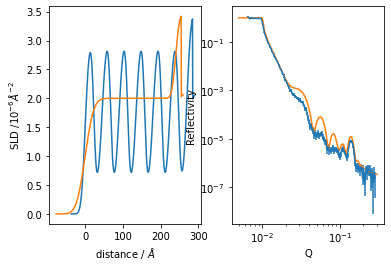

In [18]:
# use matplotlib for plotting
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path

import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, MixedReflectModel, ReflectModel, Structure, LipidLeaflet, Stack

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset


data_DiscA_1 = ReflectDataset('IvsQ_55214_55215.dat')
data_DiscA_1.name = "1pc_4000RPM"

# %matplotlib notebook
#fig, ax = plt.subplots()
# data_DiscA_1.plot()
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.yscale('log')
# plt.xscale('log')

## create slabs
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.0, name='film')
air = SLD(0.0, name='air')
OA = SLD(3.0, name='OA')
SO = SLD(0.5, name='SO')

# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(15, 8)

# the film of interest
film_layer = film(240, 18)
OA_layer = OA(23,8)
SO_layer = SO(22,5)

sio2_layer.thick.setp(bounds=(10, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

film_layer.thick.setp(bounds=(100, 500), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 4), vary=True)
film_layer.rough.setp(bounds=(1, 45), vary=True)

OA_layer.thick.setp(bounds=(10, 50), vary=True)
OA_layer.sld.real.setp(bounds=(0, 5), vary=True)
OA_layer.rough.setp(bounds=(1, 15), vary=True)

SO_layer.thick.setp(bounds=(10, 50), vary=True)
SO_layer.sld.real.setp(bounds=(-1, 2), vary=True)
SO_layer.rough.setp(bounds=(1, 15), vary=True)

# Make a multilayer by using a Stack Component
stack = Stack(components=OA_layer|SO_layer, repeats=6)
#stack |= OA_layer
#stack |= SO_layer
#stack.repeats = 10.0

# assemble the structure
structure1 = air | film_layer | sio2_layer | si 
structure2 = air | stack | sio2_layer | si



model = MixedReflectModel((structure1,structure2), scales=(0.95,0.05), bkg=3e-7, dq=2.5)
model.scales[0].setp(bounds=(0.5, 1.2), vary=True)
model.scales[1].setp(bounds=(0.0, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)


# check model
q = np.linspace(0.005, 0.3, 1001)
fig, (ax1, ax2) = plt.subplots(1,2)

# plot the SLD profile
ax1.plot(*structure2.sld_profile())
ax1.plot(*structure1.sld_profile())
ax1.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
ax1.set_xlabel('distance / $\AA$');

data_DiscA_1.plot(plt)
ax2.plot(q, model(q))
ax2.set_xlabel('Q')
ax2.set_ylabel('Reflectivity')
ax2.set_yscale('log')
ax2.set_xscale('log')


4698.330915430404 -21.0357408013944 -2029.5568204076415 -2050.592561209036


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f693f6e8748>)

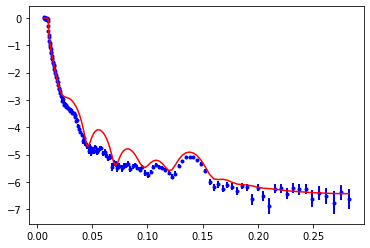

In [19]:
## create 'objective'
objective = Objective(model, data_DiscA_1, transform=Transform('logY'))
print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())
objective.plot()

In [20]:
## do the fit and plot result
fitter = CurveFitter(objective)
fitter.fit('differential_evolution')

140it [03:50,  1.65s/it]


   covar: array([[ 1.05499461e-03, -1.05814644e-03,  1.54694398e-10,
        -3.66748858e-02, -5.79735554e-04, -2.21677768e-02,
        -1.53702640e-02, -5.01976693e-02, -2.08887069e-01,
         8.31747994e-02, -3.72506338e-01,  2.04534538e-01,
        -2.54855186e-02,  1.37877041e-01],
       [-1.05814644e-03,  1.07883551e-03, -1.60288937e-10,
         3.73830943e-02,  5.79695047e-04,  2.26983124e-02,
         1.55266456e-02,  5.16051177e-02,  2.11586205e-01,
        -8.44246204e-02,  3.77956543e-01, -2.07167554e-01,
         2.58256243e-02, -1.39840193e-01],
       [ 1.54694398e-10, -1.60288937e-10,  1.75354001e-15,
         3.43679486e-08, -2.86815686e-11,  5.61963350e-09,
        -1.15082282e-08,  7.29665513e-09, -1.02681746e-07,
         6.07965390e-08, -1.25922231e-07,  1.00516500e-07,
        -1.50082474e-09,  9.07708369e-08],
       [-3.66748858e-02,  3.73830943e-02,  3.43679486e-08,
         4.41927765e+01,  6.59819626e-02,  1.00164465e+01,
        -5.21035058e+00,  1.0786288

1110.7193200498707
________________________________________________________________________________
Objective - 140090011075920
Dataset = 1pc_4000RPM
datapoints = 154
chi2 = 1110.7193200498707
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
[Parameters(data=[Parameters(data=[Parameter(value=0.7468613450258487, name='scale', vary=True, bounds=Interval(lb=0.5, ub=1.2), constraint=None), Parameter(value=0.13008796275514892, name='scale', vary=True, bounds=Interval(lb=0.0, ub=1.2), constraint=None)], name='scale factors'), Parameter(value=3.4221551630785496e-07, name='bkg', vary=True, bounds=Interval(lb=1e-09, ub=9e-06), constraint=None), Parameter(value=2.5, name='dq - resolution', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='instrument parameters')]
________________________________________________________________________________
Parameters: 'Structure

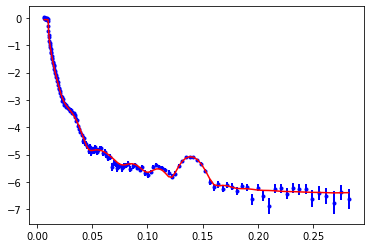

In [21]:
print(objective.chisqr())
objective.plot()
print(objective)

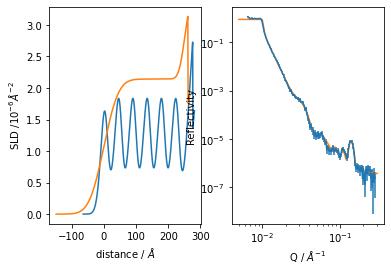

In [22]:
# check model
q = np.linspace(0.005, 0.3, 1001)
fig, (ax1, ax2) = plt.subplots(1,2)

# plot the SLD profile
ax1.plot(*structure2.sld_profile())
ax1.plot(*structure1.sld_profile())
ax1.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
ax1.set_xlabel('distance / $\AA$');

data_DiscA_1.plot(plt)
ax2.plot(q, model(q))
ax2.set_xlabel('Q / $\AA^{-1}$')
ax2.set_ylabel('Reflectivity')
ax2.set_yscale('log')
ax2.set_xscale('log')